In [1]:
%load_ext autoreload

In [2]:
%autoreload 2

# 目的
本ノートブックでは、線形回帰を行うことを前提とした、探索的データ解析（Exploratory Data Analysis:EDA）の練習を行う。

In [7]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import seaborn as sns
import matplotlib.pyplot as plt
import platform


#invite people for the Kaggle party
from scipy.stats import norm
from sklearn.preprocessing import StandardScaler
from scipy import stats

from scipy.cluster.hierarchy import dendrogram
from scipy.spatial.distance import pdist

import warnings
warnings.filterwarnings('ignore')
%matplotlib inline

import missingno as msno

import eda_preprocess as ep

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/Users/yamauchito_satoshi/Documents/data/kaggle/house-prices-advanced-regression-techniques'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session


if platform.system()=="Windows":
    #windowsの場合
    data_dirname = r"C:\Users\yamau\OneDrive\ドキュメント\Python Scripts\AI\kaggle\house-prices-advanced-regression-techniques\data"
elif platform.system()=="Linux":
    #Linuxの場合
    data_dirname=r"./data"
else:    
    # macの場合
    data_dirname = r'/Users/yamauchito_satoshi/Documents/data/kaggle/house-prices-advanced-regression-techniques'

ModuleNotFoundError: No module named 'pandas'

In [6]:
def reset_data():
    train = pd.read_csv(os.path.join(data_dirname, "train.csv"))
    test_data = pd.read_csv(os.path.join(data_dirname, "test.csv"))
    y_test = pd.read_csv(os.path.join(data_dirname, "sample_submission.csv"))["SalePrice"]
    return train, test_data, y_test

In [11]:
train, test_data, y_test = reset_data()
type(train)

pandas.core.frame.DataFrame

In [12]:
test_data

,Id,MSSubClass,MSZoning,LotFrontage,LotArea,Street,Alley,LotShape,LandContour,Utilities,...,ScreenPorch,PoolArea,PoolQC,Fence,MiscFeature,MiscVal,MoSold,YrSold,SaleType,SaleCondition
0,1461,20,RH,80.0,11622,Pave,NaN,Reg,Lvl,AllPub,...,120,0,NaN,MnPrv,NaN,0,6,2010,WD,Normal
1,1462,20,RL,81.0,14267,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,Gar2,12500,6,2010,WD,Normal
2,1463,60,RL,74.0,13830,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,MnPrv,NaN,0,3,2010,WD,Normal
3,1464,60,RL,78.0,9978,Pave,NaN,IR1,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2010,WD,Normal
4,1465,120,RL,43.0,5005,Pave,NaN,IR1,HLS,AllPub,...,144,0,NaN,NaN,NaN,0,1,2010,WD,Normal
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1454,2915,160,RM,21.0,1936,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,6,2006,WD,Normal
1455,2916,160,RM,21.0,1894,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,4,2006,WD,Abnorml
1456,2917,20,RL,160.0,20000,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,NaN,NaN,0,9,2006,WD,Abnorml
1457,2918,85,RL,62.0,10441,Pave,NaN,Reg,Lvl,AllPub,...,0,0,NaN,MnPrv,Shed,700,7,2006,WD,Normal


# 目的変数の解析
統計量、ヒストグラムにより目的変数の特徴を確認する。

In [7]:
train["SalePrice"].describe()

count      1460.000000
mean     180921.195890
std       79442.502883
min       34900.000000
25%      129975.000000
50%      163000.000000
75%      214000.000000
max      755000.000000
Name: SalePrice, dtype: float64

<AxesSubplot:xlabel='SalePrice', ylabel='Density'>

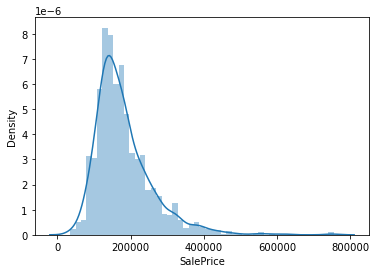

In [8]:
sns.distplot(train["SalePrice"])

In [9]:
print("歪度: %f" % train['SalePrice'].skew())
print("尖度: %f" % train['SalePrice'].kurt())

歪度: 1.882876
尖度: 6.536282


# 説明変数の解析
説明変数と目的変数間の関係を解析する。

## 連続値は散布図

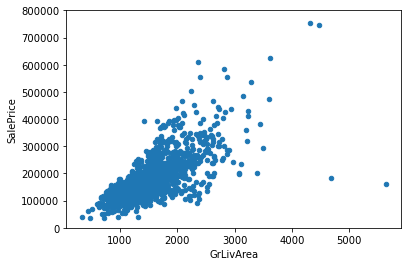

In [10]:
#説明変数と目的変数の散布図作成
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

## 離散値は散布図を箱ヒゲ図に変換したもの

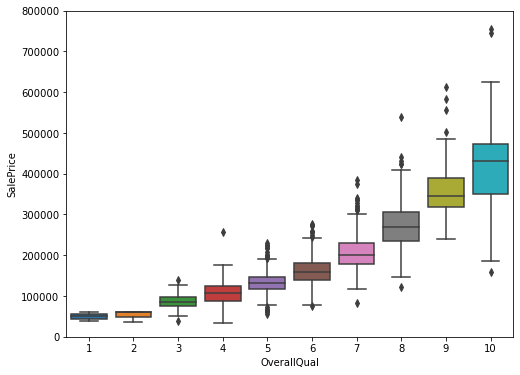

In [11]:
#box plot overallqual/saleprice
var = 'OverallQual'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);

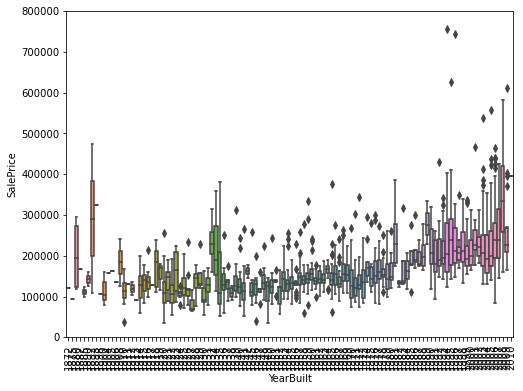

In [12]:
#box plot overallqual/saleprice
var = 'YearBuilt'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
f, ax = plt.subplots(figsize=(8, 6))
fig = sns.boxplot(x=var, y="SalePrice", data=data)
fig.axis(ymin=0, ymax=800000);
plt.xticks(rotation=90);

## まとめて見たい場合は相関行列のヒートマップ

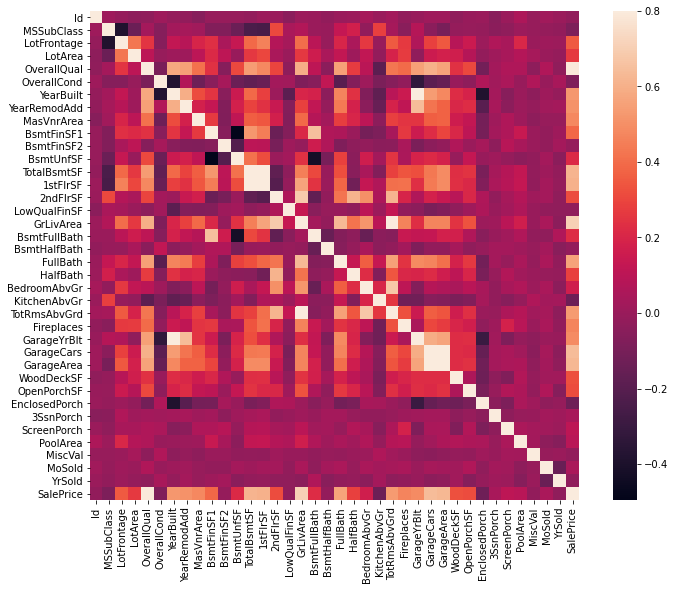

In [13]:
#correlation matrix
corrmat = train.corr()
f, ax = plt.subplots(figsize=(12, 9))
sns.heatmap(corrmat, vmax=.8, square=True);

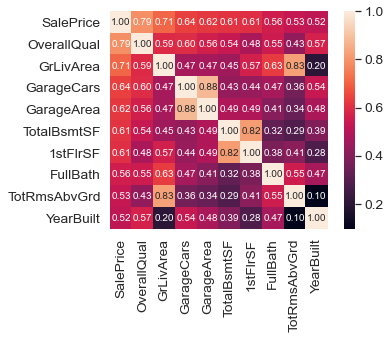

In [14]:
#目的変数と特に相関が強い10個を選択

#saleprice correlation matrix
k = 10 #number of variables for heatmap
cols = corrmat.nlargest(k, 'SalePrice')['SalePrice'].index
cm = np.corrcoef(train[cols].values.T)
sns.set(font_scale=1.25)
hm = sns.heatmap(cm, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10}, yticklabels=cols.values, xticklabels=cols.values)
plt.show()

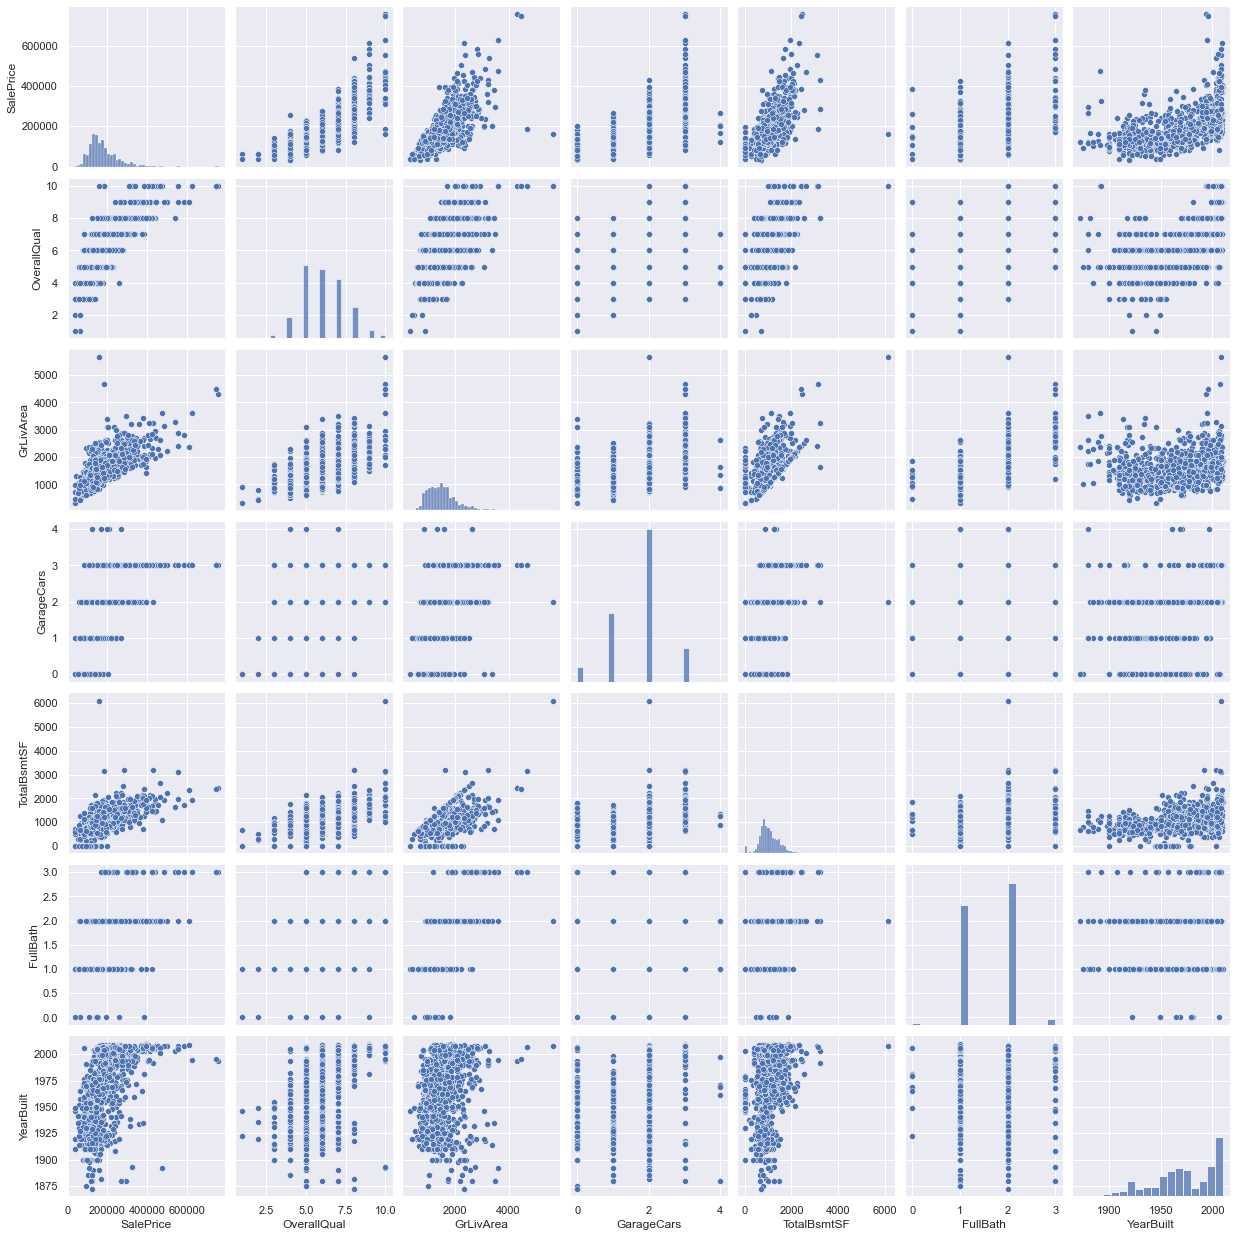

In [15]:
#scatterplot
sns.set()
cols = ['SalePrice', 'OverallQual', 'GrLivArea', 'GarageCars', 'TotalBsmtSF', 'FullBath', 'YearBuilt']
sns.pairplot(train[cols], size = 2.5)
plt.show();

# 【独自処理】目的変数との相関がある説明変数同士のクラスタリング
説明変数間の相関係数を類似度として階層型クラスタリングを行う。

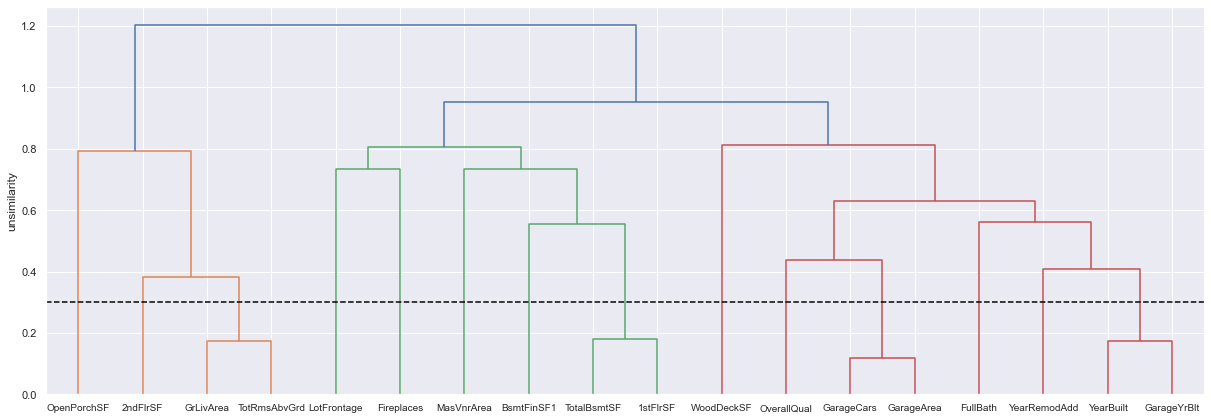

In [16]:


selected_label, distmat, row_clusters = ep.var_select_by_clustring(corrmat, "SalePrice")

plt.figure(figsize=(17,6))
row_dendr = dendrogram(row_clusters, labels=distmat.index, leaf_font_size=10)
plt.ylabel("unsimilarity")
plt.hlines([0.3],  0, 1000, "black", linestyles='dashed')
plt.tight_layout()
plt.show()

In [17]:
selected_label = ep.highcorr_compare(selected_label, distmat, corrmat, "SalePrice")
selected_label

['LotFrontage',
 'OverallQual',
 'YearRemodAdd',
 'MasVnrArea',
 'BsmtFinSF1',
 'TotalBsmtSF',
 '1stFlrSF',
 'GrLivArea',
 'FullBath',
 'TotRmsAbvGrd',
 'Fireplaces',
 'GarageCars',
 'GarageArea',
 'WoodDeckSF',
 'OpenPorchSF']

# 欠損値に対する処理
- 15%以上が欠損値の場合は、その変数は削除してないものと扱う。この時は、何らかの処理でその欠損値を埋めるべきではない。

In [18]:
train, test_data, y_test = reset_data()

In [19]:
#missing data
missing_data_train = ep.missing_data_analysis(train)
missing_data_train.head(20)

,Total,Percent
PoolQC,1453,0.995205
MiscFeature,1406,0.963014
Alley,1369,0.937671
Fence,1179,0.807534
FireplaceQu,690,0.472603
LotFrontage,259,0.177397
GarageYrBlt,81,0.055479
GarageCond,81,0.055479
GarageType,81,0.055479
GarageFinish,81,0.055479


In [20]:
ep.missing_data_analysis(test_data).head(20)

,Total,Percent
PoolQC,1456,0.997944
MiscFeature,1408,0.965045
Alley,1352,0.926662
Fence,1169,0.801234
FireplaceQu,730,0.500343
LotFrontage,227,0.155586
GarageYrBlt,78,0.053461
GarageQual,78,0.053461
GarageFinish,78,0.053461
GarageCond,78,0.053461


<AxesSubplot:>

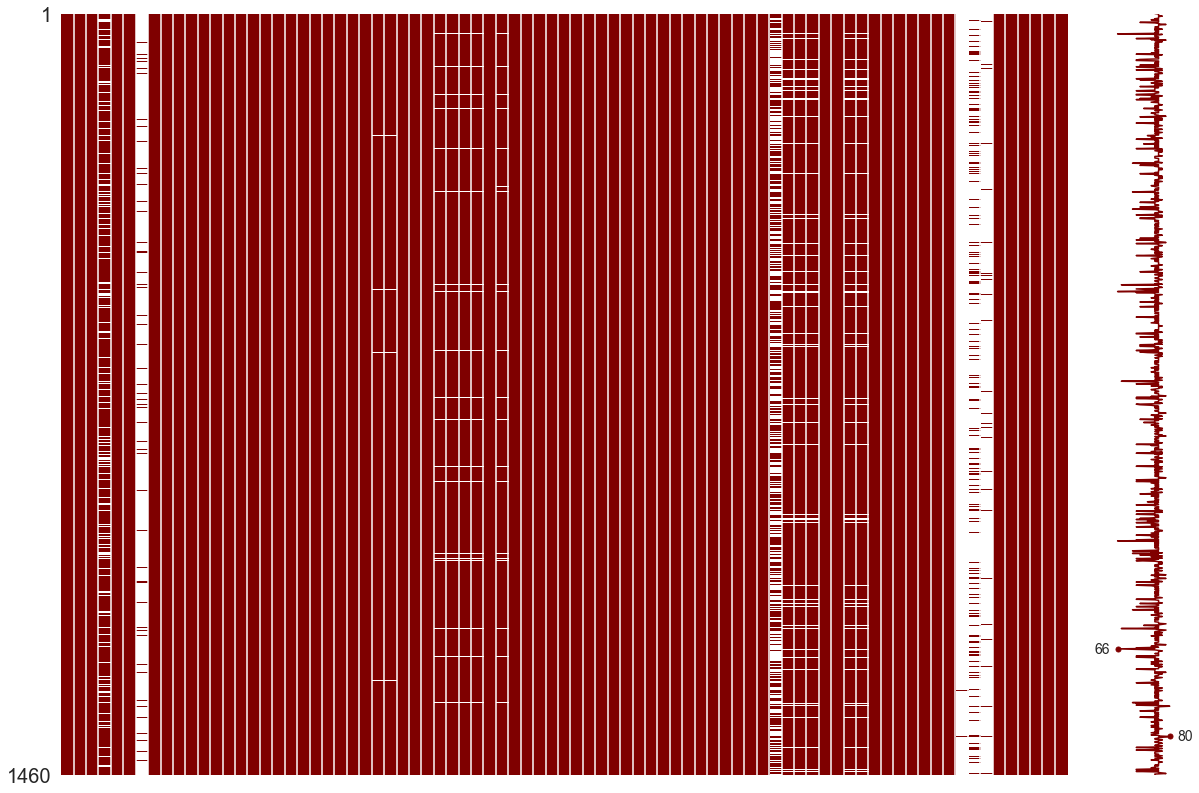

In [21]:
#以下のように欠損値のあるデータをマトリックス形式で可視化も可能。
msno.matrix(df=train, figsize=(20,14), color=(0.5,0,0))

In [22]:
#dealing with missing data

train = train.drop((missing_data_train[missing_data_train['Total'] > 1]).index,1)
train = train.drop(train.loc[train['Electrical'].isnull()].index)
train.isnull().sum().max() #just checking that there's no missing data missing...

0

In [23]:
#dealing with missing data

test_data = test_data.drop((missing_data_train[missing_data_train['Total'] > 1]).index,1)
test_data = test_data.drop(test_data.loc[test_data['Electrical'].isnull()].index)


missing_data_test = ep.missing_data_analysis(test_data)
test_data=test_data.fillna(test_data.mean())
test_data = test_data.fillna(method="ffill")

test_data.isnull().sum().max() #just checking that there's no missing data missing...

0

# 外れ値処理

In [24]:
#standardizing data
saleprice_scaled = StandardScaler().fit_transform(train['SalePrice'][:,np.newaxis]);
low_range = saleprice_scaled[saleprice_scaled[:,0].argsort()][:10]
high_range= saleprice_scaled[saleprice_scaled[:,0].argsort()][-10:]
print('outer range (low) of the distribution:')
print(low_range)
print('\nouter range (high) of the distribution:')
print(high_range)

outer range (low) of the distribution:
[[-1.83820775]
 [-1.83303414]
 [-1.80044422]
 [-1.78282123]
 [-1.77400974]
 [-1.62295562]
 [-1.6166617 ]
 [-1.58519209]
 [-1.58519209]
 [-1.57269236]]

outer range (high) of the distribution:
[[3.82758058]
 [4.0395221 ]
 [4.49473628]
 [4.70872962]
 [4.728631  ]
 [5.06034585]
 [5.42191907]
 [5.58987866]
 [7.10041987]
 [7.22629831]]


*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


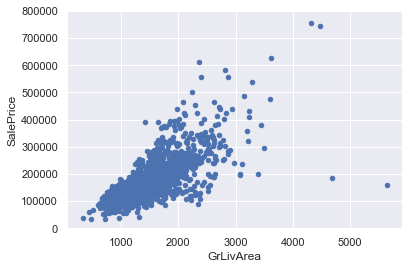

In [25]:
#bivariate analysis saleprice/grlivarea
var = 'GrLivArea'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

In [26]:
#deleting points
train.sort_values(by = 'GrLivArea', ascending = False)[:2]
train = train.drop(train[train['Id'] == 1299].index)
train = train.drop(train[train['Id'] == 524].index)

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2-D array with a single row if you intend to specify the same RGB or RGBA value for all points.


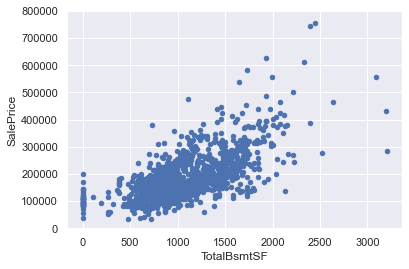

In [27]:
#bivariate analysis saleprice/grlivarea
var = 'TotalBsmtSF'
data = pd.concat([train['SalePrice'], train[var]], axis=1)
data.plot.scatter(x=var, y='SalePrice', ylim=(0,800000));

# 中核の解析
- 正規性の解析

## 正規性の解析
歪度が正の値をとり、正規確率プロットが直線とならないため、正規分布ではない。たたし、今回のように右に裾が長い分布の場合は、対数変換が有効な可能性がある。


なぜ正規分布に従わせる必要がある？

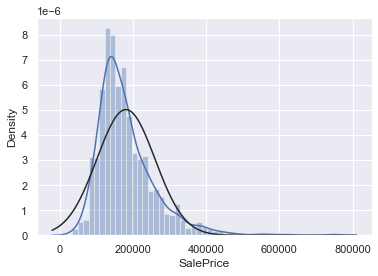

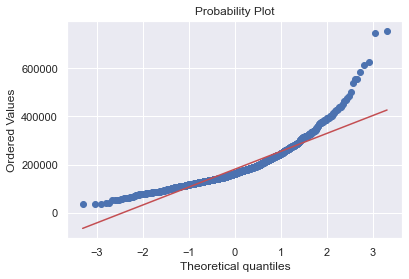

In [28]:
#histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

In [29]:
#applying log transformation
train['SalePrice'] = np.log(train['SalePrice'])

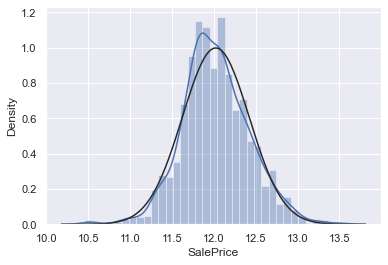

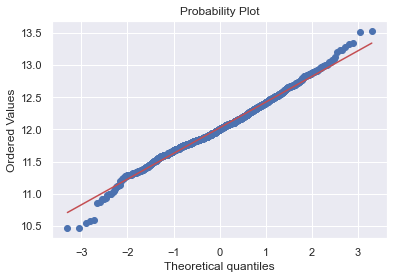

In [30]:
#transformed histogram and normal probability plot
sns.distplot(train['SalePrice'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['SalePrice'], plot=plt)

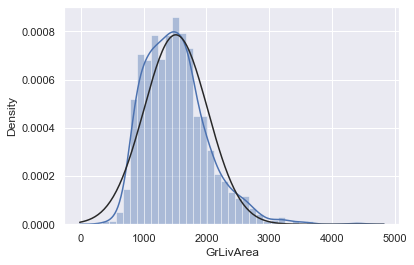

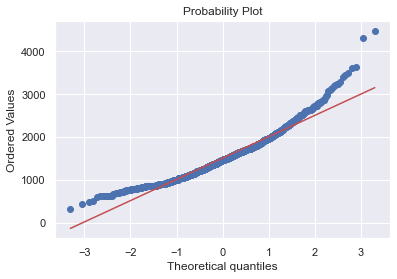

In [31]:
#histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

In [32]:
#data transformation
train['GrLivArea'] = np.log(train['GrLivArea'])
test_data['GrLivArea'] = np.log(test_data['GrLivArea'])

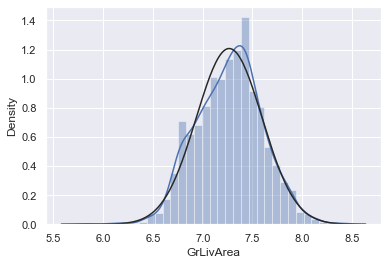

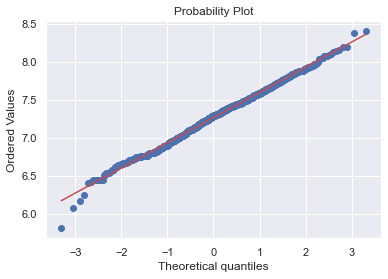

In [33]:
#transformed histogram and normal probability plot
sns.distplot(train['GrLivArea'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['GrLivArea'], plot=plt)

以下のように、観測値が0のために対数を取れない場合は、値を持つかどうかの２値変数を新たに説明変数に追加する。そして、対数を取れるデータのみについて対数変換を行う。

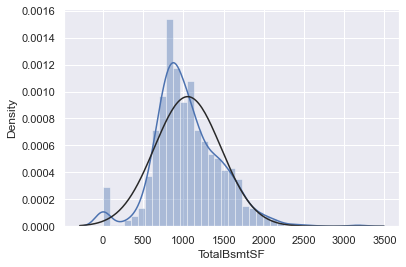

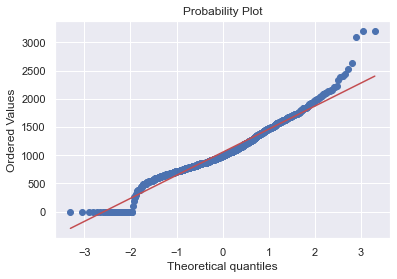

In [34]:
#histogram and normal probability plot
sns.distplot(train['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train['TotalBsmtSF'], plot=plt)

In [35]:
#create column for new variable (one is enough because it's a binary categorical feature)
#if area>0 it gets 1, for area==0 it gets 0
train['HasBsmt'] = pd.Series(len(train['TotalBsmtSF']), index=train.index)
train['HasBsmt'] = 0 
train.loc[train['TotalBsmtSF']>0,'HasBsmt'] = 1

test_data['HasBsmt'] = pd.Series(len(test_data['TotalBsmtSF']), index=test_data.index)
test_data['HasBsmt'] = 0 
test_data.loc[test_data['TotalBsmtSF']>0,'HasBsmt'] = 1

In [36]:
#transform data
train.loc[train['HasBsmt']==1,'TotalBsmtSF'] = np.log(train['TotalBsmtSF'])
test_data.loc[test_data['HasBsmt']==1,'TotalBsmtSF'] = np.log(test_data['TotalBsmtSF'])

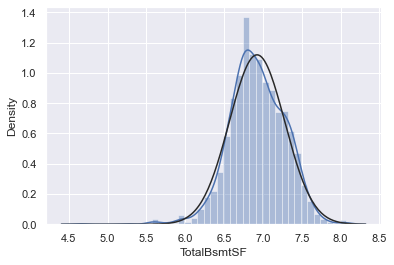

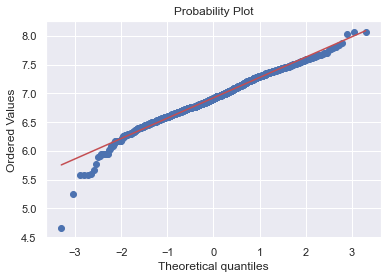

In [37]:
#histogram and normal probability plot
sns.distplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], fit=norm);
fig = plt.figure()
res = stats.probplot(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], plot=plt)

## 等分散性の確認
正規性が満たされるように上でデータ変換を行うことで、以下のように等分散性の課題を解決できる。

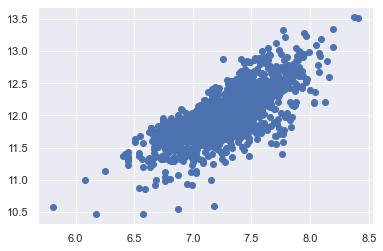

In [38]:
#scatter plot
plt.scatter(train['GrLivArea'], train['SalePrice']);

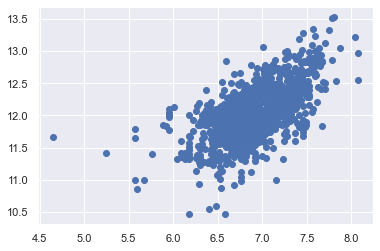

In [39]:
#scatter plot
plt.scatter(train[train['TotalBsmtSF']>0]['TotalBsmtSF'], train[train['TotalBsmtSF']>0]['SalePrice']);

In [40]:
X_train = train.drop(["SalePrice"], axis=1)
y_train = train["SalePrice"]


X_test = test_data
y_test = np.log(pd.read_csv(os.path.join(data_dirname, "sample_submission.csv"))["SalePrice"])

In [41]:
train_size = X_train.shape[0]
test_size = X_test.shape[0]

X_total = pd.concat([X_train, X_test], axis=0)

# クラスタリング結果を反映する

In [42]:
for l in selected_label:
    if l not in X_total.columns:
        print(l)
        selected_label.remove(l)

LotFrontage
MasVnrArea


In [43]:
X_total=X_total.loc[:,selected_label]

In [44]:
X_total.select_dtypes(include=float).columns

Index(['BsmtFinSF1', 'TotalBsmtSF', 'GrLivArea', 'GarageCars', 'GarageArea'], dtype='object')

# カテゴリ変数を変換

In [45]:
X_total = pd.get_dummies(X_total)

In [46]:
X_train = X_total[:train_size]
X_test = X_total[train_size:train_size+test_size]

# 前処理の一括処理

In [7]:
#自作前処理の場合
train, test_data, y_test = reset_data()
X_train, y_train, X_valid, y_valid, X_test, y_test = ep.preprocess_selfmade(train, test_data, y_test)

LotFrontage
MasVnrArea


In [142]:
#xgb用前処理の場合
train, test_data, y_test = reset_data()
X_train, y_train, X_valid, y_valid, X_test = ep.preprocess_for_xgb(train, test_data)

# 線形モデルの作成
以下のモデルで線形回帰を行う。
- 正則化なしの線形回帰
- リッジ回帰
- Lasso回帰

## 正則化なしの線形回帰

MSE_train=0.021734360273066886, r2_train=0.8656020879725916
MSE_test=0.01888625559795033, r2_test=0.8755629794537485


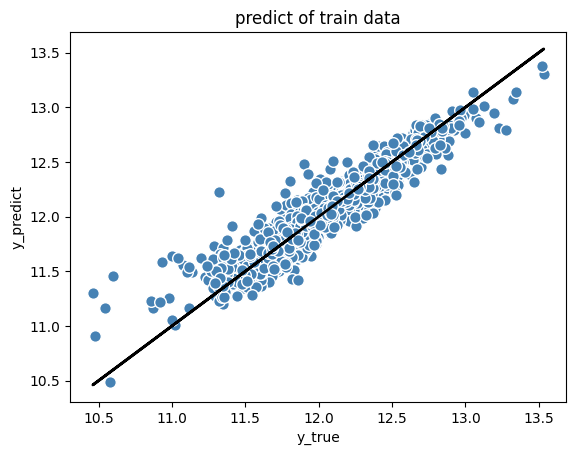

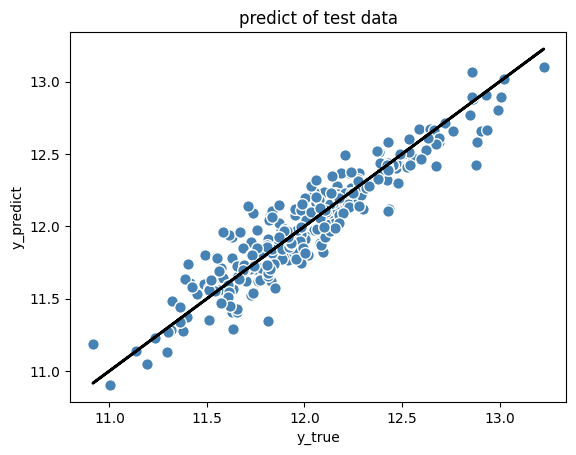

In [14]:
from sklearn.linear_model import LinearRegression, Ridge, Lasso, RidgeCV, LassoCV
from sklearn.svm import SVR

slr = LinearRegression()
slr.fit(X_train, y_train)

eva_class = ep.evaluation_show(X_train, y_train, X_valid, y_valid, slr)
eva_class.show_result()

## リッジ回帰
クロスバリデーションに基づくリッジ回帰

alpha= 1.0
MSE_train=0.02173780361537335, r2_train=0.8655807955116878
MSE_test=0.018829840893272873, r2_test=0.8759346824484819


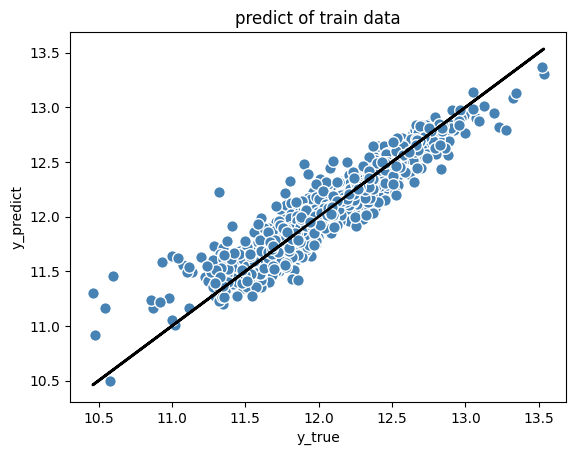

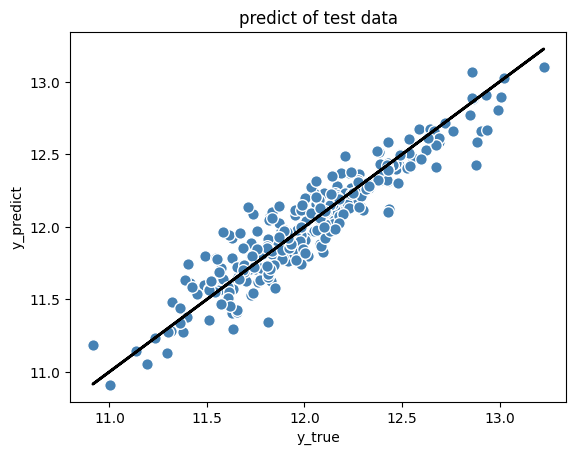

In [8]:
slr = RidgeCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)
slr.fit(X_train, y_train)
print("alpha=", slr.alpha_)

eva_class = ep.evaluation_show(X_train, y_train, X_valid, y_valid, slr)
eva_class.show_result()

## Lasso回帰

alpha= 0.01
MSE_train=0.02488216492017675, r2_train=0.8461371317131708
MSE_test=0.02056613333113216, r2_test=0.8644946668962384


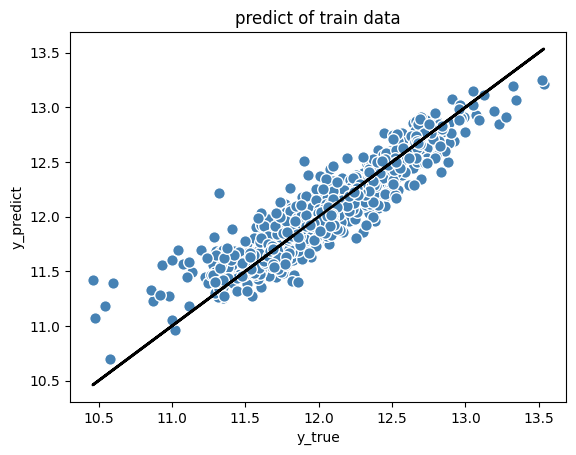

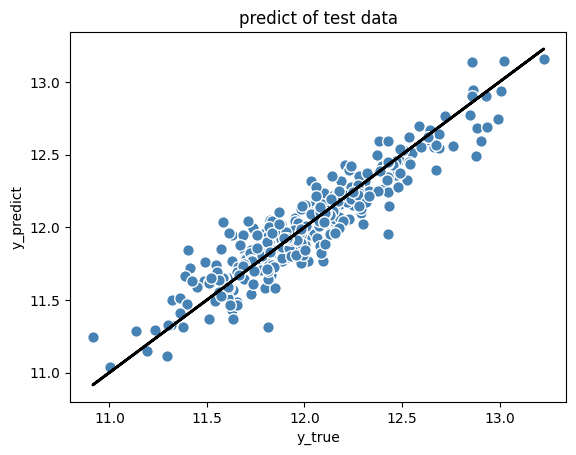

In [9]:
slr = LassoCV(alphas=[0.01, 0.1, 1, 10, 100], cv=5)
slr.fit(X_train, y_train)
print("alpha=", slr.alpha_)

eva_class = ep.evaluation_show(X_train, y_train, X_valid, y_valid, slr)
eva_class.show_result()

# 非線形モデルの作成
- SV回帰
- ランダムフォレスト回帰
- ニューラルネットワーク

### 線形カーネルを使った場合

In [11]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

# tuned_parameters = [
#     {'kernel': ['linear'], 'C': [1, 10, 100, 1000]}
# ]

# gscv = GridSearchCV(SVR(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
# gscv.fit(X_train, y_train)

# #一番スコア悪い&良い奴を出す
# #params_min,_,_ = gscv.grid_scores_[np.argmin([x[1] for x in gscv.grid_scores_])]
# params_min = gscv.best_params_
# #reg_min = SVR(kernel=params_min['kernel'], C=params_min['C'], gamma=params_min['gamma'])
# reg_min = SVR(kernel=params_min['kernel'], C=params_min['C'])

# reg_max = gscv.best_estimator_
# #全トレーニングデータを使って再推計
# reg_min.fit(X_train, y_train)


# show_result(X_train, y_train, X_test, y_test, reg_min)

### rbfカーネルを使った場合

In [181]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV

tuned_parameters = [
    {'kernel': ['rbf'], 'gamma': [10**i for i in range(-4,3)], 'C': [10**i for i in range(-3, 4)]}
]

gscv = GridSearchCV(SVR(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=SVR(),
             param_grid=[{'C': [0.001, 0.01, 0.1, 1, 10, 100, 1000],
                          'gamma': [0.0001, 0.001, 0.01, 0.1, 1, 10, 100],
                          'kernel': ['rbf']}],
             scoring='neg_mean_squared_error')

In [182]:
print(gscv.best_params_)

{'C': 1, 'gamma': 0.0001, 'kernel': 'rbf'}


MSE_train=0.012555761536838237, r2_train=0.9223594293430294
MSE_test=0.09584959815311594, r2_test=0.3684699249742407


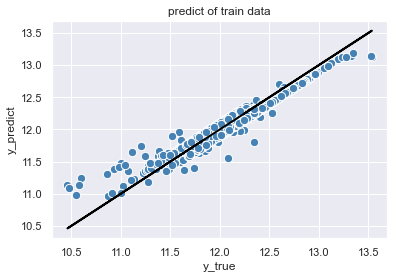

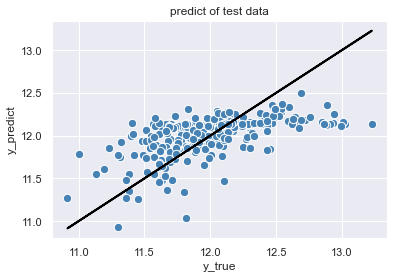

In [183]:
#一番スコア悪い&良い奴を出す
#params_min,_,_ = gscv.grid_scores_[np.argmin([x[1] for x in gscv.grid_scores_])]
params_min = gscv.best_params_
reg_min = SVR(kernel=params_min['kernel'], C=params_min['C'], gamma=params_min['gamma'])

reg_max = gscv.best_estimator_
#全トレーニングデータを使って再推計
reg_min.fit(X_train, y_train)

eva_class = ep.evaluation_show(X_train, y_train, X_valid, y_valid, reg_min)
eva_class.show_result()

## ランダムフォレスト回帰

In [184]:
from sklearn import model_selection
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor

tuned_parameters = [
    {'n_estimators': [10, 50, 100], 'max_features': ["sqrt", "log2"], 'max_depth': [10, 50, 100]}
]

gscv = GridSearchCV(RandomForestRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X_train, y_train)


GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid=[{'max_depth': [10, 50, 100],
                          'max_features': ['sqrt', 'log2'],
                          'n_estimators': [10, 50, 100]}],
             scoring='neg_mean_squared_error')

In [185]:
print(gscv.best_params_)

{'max_depth': 100, 'max_features': 'sqrt', 'n_estimators': 100}


MSE_train=0.0030731182789864113, r2_train=0.9809968789087917
MSE_test=0.01884877862101314, r2_test=0.8758099062903021


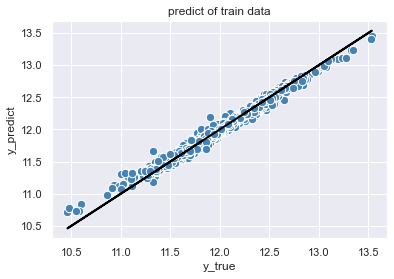

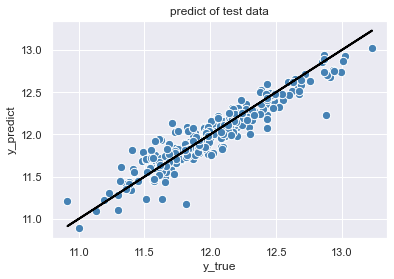

In [186]:
#一番スコア悪い&良い奴を出す
#params_min,_,_ = gscv.grid_scores_[np.argmin([x[1] for x in gscv.grid_scores_])]
params_min = gscv.best_params_
reg_min = RandomForestRegressor(max_depth=params_min["max_depth"], max_features=params_min["max_features"], n_estimators=params_min["n_estimators"])

reg_max = gscv.best_estimator_
#全トレーニングデータを使って再推計
reg_min.fit(X_train, y_train)

eva_class = ep.evaluation_show(X_train, y_train, X_valid, y_valid, reg_min)
eva_class.show_result()

# 勾配ブースティング木

In [12]:
from xgboost import XGBRegressor


tuned_parameters = [
    {
    'n_estimators': [10, 100, 1000], 
    #'max_depth': [3, 5, 10, 15, 20, 25, 30, 40, 50, 100], 
    "learning_rate": [0.05, 0.1]
    }
]

gscv = GridSearchCV(XGBRegressor(), tuned_parameters, cv=5, scoring='neg_mean_squared_error')
gscv.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None, gpu_id=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, m...
                                    max_cat_threshold=None,
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None, n_estimators=100,
                                    n_jobs=None, num_parallel_tree=None,
                                    predictor=None, random_state=None, ...),
             param_grid=[{'learning_rate': [0.05, 0.1],
                          'n_estimators': [10, 100, 1000]}],
             scoring='neg_mean_squared_error')

In [13]:
print(gscv.best_params_)

{'learning_rate': 0.1, 'n_estimators': 100}


MSE_train=0.004626389480324228, r2_train=0.9713919766411692
MSE_test=0.020519141601374035, r2_test=0.8648042841632022


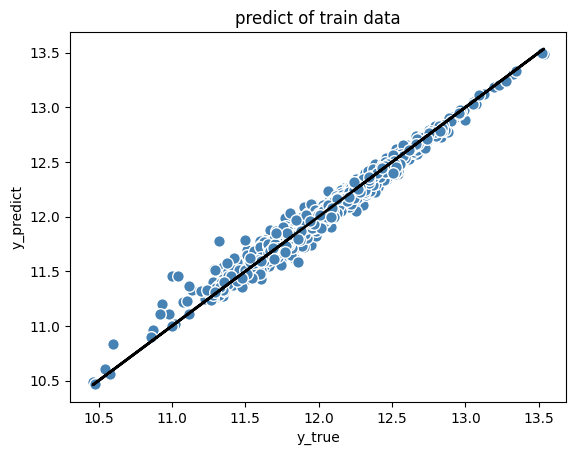

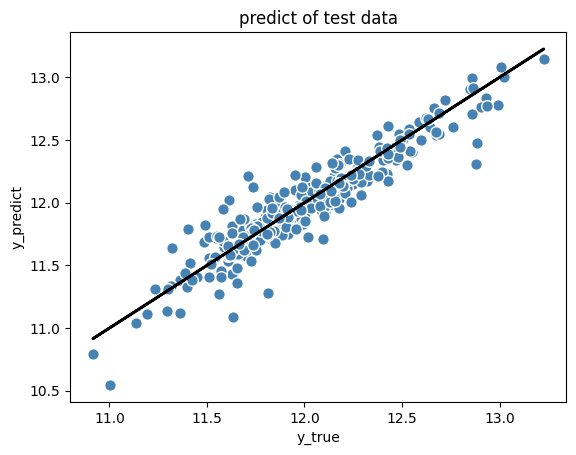

In [14]:

# Define the model
xgb =  XGBRegressor(learning_rate=gscv.best_params_["learning_rate"],
                    n_estimators=gscv.best_params_["n_estimators"]
                    #, max_depth=gscv.best_params_["max_depth"]
                    )

# Fit the model
xgb.fit(X_train, y_train)

eva_class = ep.evaluation_show(X_train, y_train, X_valid, y_valid, xgb)
eva_class.show_result()

# ニューラルネットワーク回帰

## pytorchでの実装

In [24]:
net(x_tensor)

tensor([[3.9624],
        [1.6801],
        [5.5241],
        ...,
        [8.5632],
        [7.1973],
        [8.8242]], grad_fn=<AddmmBackward0>)

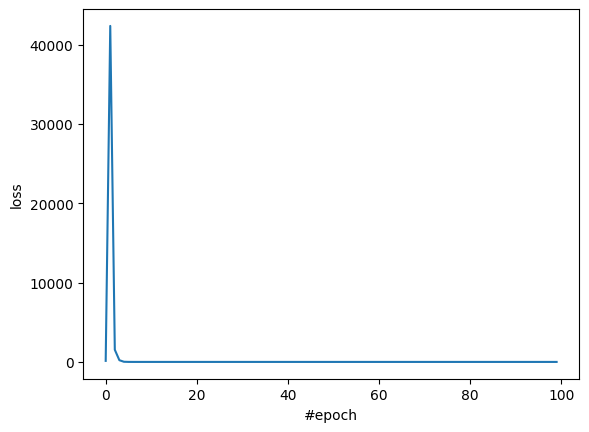

In [15]:
import torch

import torch
import torch.nn.functional
import torch.utils.data

class Net(torch.nn.Module):

  def __init__(self):
    super(Net, self).__init__()
    self.fc1 = torch.nn.Linear(X_train.shape[1], 256)
    self.fc2 = torch.nn.Linear(256, 128)
    self.fc3 = torch.nn.Linear(128, 64)
    self.fc4 = torch.nn.Linear(64, 32)
    self.fc5 = torch.nn.Linear(32, 1)

  def forward(self, x):
    x = torch.nn.functional.relu(self.fc1(x))
    x = torch.nn.functional.relu(self.fc2(x))
    x = torch.nn.functional.relu(self.fc3(x))
    x = torch.nn.functional.relu(self.fc4(x))
    x = self.fc5(x)
    return x


num_epochs = 100

x_tensor = torch.from_numpy(X_train.values).float()
y_tensor = torch.from_numpy(y_train.values.reshape(-1, 1)).float()

net = Net()
net.train()
#optimizer = torch.optim.SGD(net.parameters(), lr=0.001)
optimizer = torch.optim.RMSprop(net.parameters(), lr=0.001) 
criterion = torch.nn.MSELoss()

epoch_loss = []
for epoch in range(num_epochs):
  
  optimizer.zero_grad()
  y_pred = net(x_tensor)
  loss = criterion(y_pred, y_tensor)
  
  loss.backward()
  optimizer.step()
    
  epoch_loss.append(loss.data.numpy().tolist())

fig = plt.figure()
ax = fig.add_subplot()
ax.plot(list(range(len(epoch_loss))), epoch_loss)
ax.set_xlabel('#epoch')
ax.set_ylabel('loss')
fig.show()

MSE_train=0.1972386787094284, r2_train=-0.21965708935271477
MSE_test=0.21523795627836723, r2_test=-0.4181514090411391


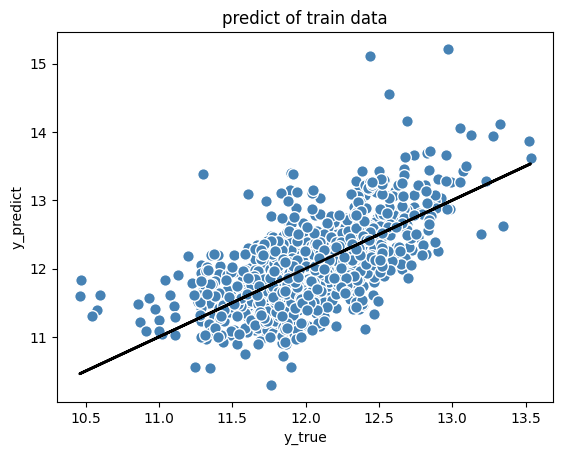

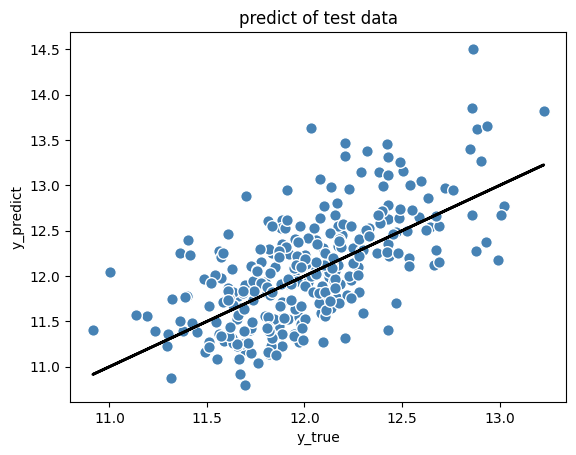

In [16]:
eva_class = ep.evaluation_show_pytorch(X_train, y_train, X_valid, y_valid, net)
eva_class.show_result()

## Optunaによるpytorchのパラメータチューニング

In [24]:
import optuna

In [25]:
study=optuna.create_study()

[I 2022-11-06 15:31:15,372] A new study created in memory with name: no-name-4b03e08c-fe5e-42aa-ae63-9d4cac9ea781


## kerasでの実装

In [16]:
# create regression model
def reg_model():
    model = Sequential()
    model.add(Dense(20, input_dim=X_train.shape[1], activation='relu'))
    model.add(Dense(1))

    # compile model
    model.compile(loss='mse', optimizer='adam', metrics=['mae', 'mse'])
    return model


In [17]:
from keras.wrappers.scikit_learn import KerasRegressor

estimator = KerasRegressor(build_fn=reg_model, epochs=100, batch_size=10, verbose=0)
estimator.fit(X_train, y_train)

MSE_train=0.2740951064630114, r2_train=-0.6949111702730069
MSE_test=0.2804482425308983, r2_test=-0.8478063868713555


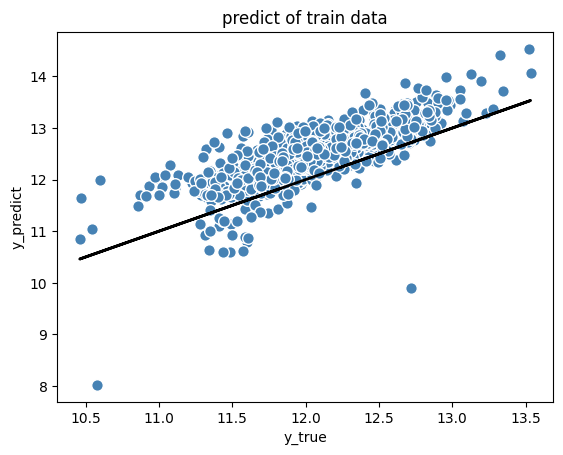

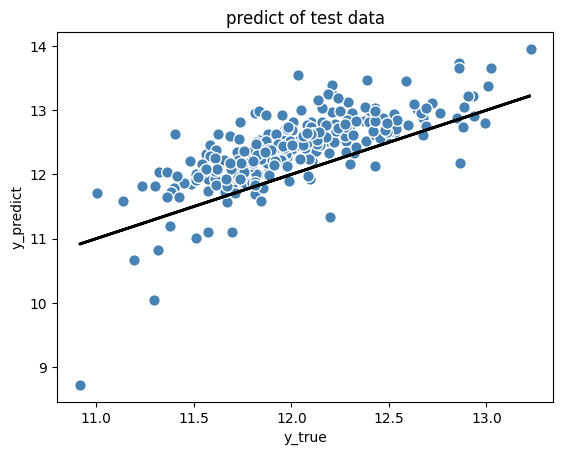

In [18]:

eva_class = ep.evaluation_show(X_train, y_train, X_valid, y_valid, estimator)
eva_class.show_result()

In [51]:
from sklearn.model_selection import KFold, cross_val_score

# use Kfold and cross validation to run the model
seed = 7
np.random.seed(seed)
estimator = KerasRegressor(build_fn=reg_model, epochs=100, batch_size=10, verbose=0)
kfold = KFold(n_splits=10, random_state=seed, shuffle=True)

# show its root mean square error
results = cross_val_score(estimator, X_train, y_train, scoring='neg_mean_squared_error', cv=kfold)
mse = -results.mean()
print("KERAS REG RMSE : %.2f" % (mse ** 0.5))

KERAS REG RMSE : 0.58


## hyperoptによるチューニング

In [ ]:
ep.

In [51]:
from hyperopt import hp
from keras.callbacks import EarlyStopping
from keras.layers import ReLU, PReLU
from keras.layers.core import Dense, Dropout
from keras.layers import BatchNormalization
from keras.models import Sequential
from keras.optimizers import SGD, Adam
from sklearn.preprocessing import StandardScaler

# 基本となるパラメータ
base_param = {
    'input_dropout': 0.0,
    'hidden_layers': 3,
    'hidden_units': 96,
    'hidden_activation': 'relu',
    'hidden_dropout': 0.2,
    'batch_norm': 'before_act',
    'optimizer': {'type': 'adam', 'lr': 0.001},
    'batch_size': 64,
}

# 探索するパラメータの空間を指定する
# param_space = {
#     'input_dropout': hp.quniform('input_dropout', 0, 0.2, 0.05),
#     'hidden_layers': hp.quniform('hidden_layers', 2, 4, 1),
#     'hidden_units': hp.quniform('hidden_units', 32, 256, 32),
#     'hidden_activation': hp.choice('hidden_activation', ['prelu', 'relu']),
#     'hidden_dropout': hp.quniform('hidden_dropout', 0, 0.3, 0.05),
#     'batch_norm': hp.choice('batch_norm', ['before_act', 'no']),
#     'optimizer': hp.choice('optimizer',
#                            [{'type': 'adam',
#                              'lr': hp.loguniform('adam_lr', np.log(0.00001), np.log(0.01))},
#                             {'type': 'sgd',
#                              'lr': hp.loguniform('sgd_lr', np.log(0.00001), np.log(0.01))}]),
#     'batch_size': hp.quniform('batch_size', 32, 128, 32),
# }

param_space = {
    'input_dropout': hp.quniform('input_dropout', 0, 0.2, 0.05),
    'hidden_layers': hp.quniform('hidden_layers', 2, 4, 1),
    'hidden_units': hp.quniform('hidden_units', 32, 256, 32),
    'hidden_activation': hp.choice('hidden_activation', ['prelu', 'relu']),
    'hidden_dropout': hp.quniform('hidden_dropout', 0, 0.3, 0.05),
    'batch_norm': hp.choice('batch_norm', ['before_act']),
    'optimizer': hp.choice('optimizer',
                           [{'type': 'adam',
                             'lr': hp.loguniform('adam_lr', np.log(0.00001), np.log(0.01))},
                            {'type': 'sgd',
                             'lr': hp.loguniform('sgd_lr', np.log(0.00001), np.log(0.01))}]),
    'batch_size': hp.quniform('batch_size', 32, 128, 32),
}

In [52]:
from sklearn.model_selection import train_test_split

X_train_keras, X_valid_keras, y_train_keras, y_valid_keras = train_test_split(X_train, y_train,
                                                                    train_size=0.8,
                                                                    test_size=0.2,
                                                                    random_state=0)

In [53]:
# -----------------------------------
# パラメータチューニングの実行

from hyperopt import fmin, tpe, STATUS_OK, Trials
from sklearn.metrics import mean_squared_error


def score(params):
    # パラメータセットを指定したときに最小化すべき関数を指定する
    # モデルのパラメータ探索においては、モデルにパラメータを指定して学習・予測させた場合のスコアとする
    model = ep.MLP(params)
    model.fit(X_train_keras, y_train_keras, X_valid_keras, y_valid_keras)
    va_pred = model.predict(X_valid_keras)
    score = mean_squared_error(y_valid_keras, va_pred)
    print(f'params: {params}, logloss: {score:.4f}')

    # 情報を記録しておく
    history.append((params, score))

    return {'loss': score, 'status': STATUS_OK}


# hyperoptによるパラメータ探索の実行
max_evals = 10
trials = Trials()
history = []
fmin(score, param_space, algo=tpe.suggest, trials=trials, max_evals=max_evals)

# 記録した情報からパラメータとスコアを出力する
# trialsからも情報が取得できるが、パラメータを取得しにくい
history = sorted(history, key=lambda tpl: tpl[1])
best = history[0]
print(f'best params:{best[0]}, score:{best[1]:.4f}')


Epoch 1/200                                          

15/15 [==============================] - 1s 8ms/step - loss: 72.7180 - mae: 8.2792 - mse: 72.7180 - val_loss: 86.8837 - val_mae: 9.2836 - val_mse: 86.8837

Epoch 2/200                                          

15/15 [==============================] - 0s 4ms/step - loss: 8.6828 - mae: 2.4344 - mse: 8.6828 - val_loss: 35.6572 - val_mae: 5.7823 - val_mse: 35.6572

Epoch 3/200                                          

15/15 [==============================] - 0s 3ms/step - loss: 3.3856 - mae: 1.4892 - mse: 3.3856 - val_loss: 27.3291 - val_mae: 4.9247 - val_mse: 27.3291

Epoch 4/200                                          

15/15 [==============================] - 0s 3ms/step - loss: 1.8819 - mae: 1.0814 - mse: 1.8819 - val_loss: 27.1430 - val_mae: 4.9642 - val_mse: 27.1430

Epoch 5/200                                          

15/15 [==============================] - 0s 3ms/step - loss: 1.7066 - mae: 1.0237 - mse: 1.7066 - val_loss:

In [58]:
model = ep.MLP(best[0])
history = model.fit(X_train_keras, y_train_keras, X_valid_keras, y_valid_keras)

Epoch 1/200
15/15 [==============================] - 1s 9ms/step - loss: 82.0369 - mae: 8.8195 - mse: 82.0369 - val_loss: 87.9827 - val_mae: 9.3541 - val_mse: 87.9827
Epoch 2/200
15/15 [==============================] - 0s 3ms/step - loss: 12.2867 - mae: 2.9705 - mse: 12.2867 - val_loss: 50.5739 - val_mae: 7.0534 - val_mse: 50.5739
Epoch 3/200
15/15 [==============================] - 0s 3ms/step - loss: 3.3813 - mae: 1.4764 - mse: 3.3813 - val_loss: 31.4775 - val_mae: 5.4368 - val_mse: 31.4775
Epoch 4/200
15/15 [==============================] - 0s 3ms/step - loss: 2.1133 - mae: 1.1401 - mse: 2.1133 - val_loss: 25.7549 - val_mae: 4.8635 - val_mse: 25.7549
Epoch 5/200
15/15 [==============================] - 0s 3ms/step - loss: 1.8434 - mae: 1.0799 - mse: 1.8434 - val_loss: 15.1656 - val_mae: 3.6352 - val_mse: 15.1656
Epoch 6/200
15/15 [==============================] - 0s 3ms/step - loss: 1.6692 - mae: 1.0180 - mse: 1.6692 - val_loss: 17.3867 - val_mae: 3.9904 - val_mse: 17.3867
Epoch 

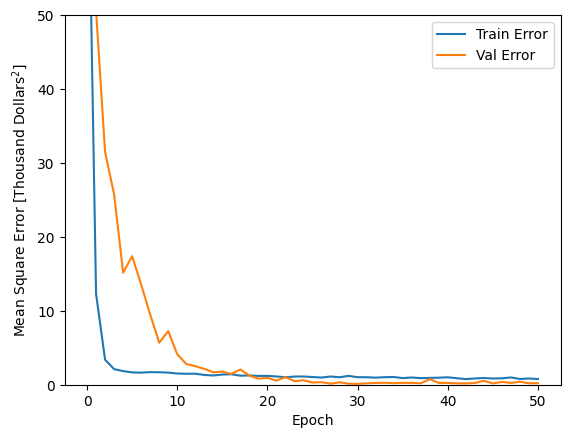

In [62]:
hist = pd.DataFrame(history.history)
hist['epoch'] = history.epoch

ep.plot_history(hist)

10/10 [==============================] - 0s 940us/step
MSE_train=0.0965057104387804, r2_train=0.40324141963514226
MSE_test=0.09503076679184934, r2_test=0.37386500894932506


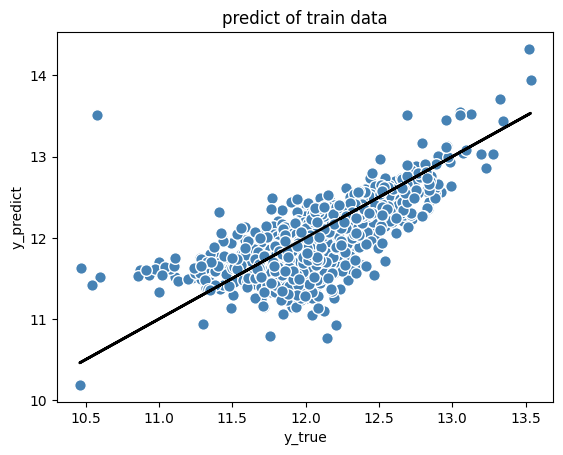

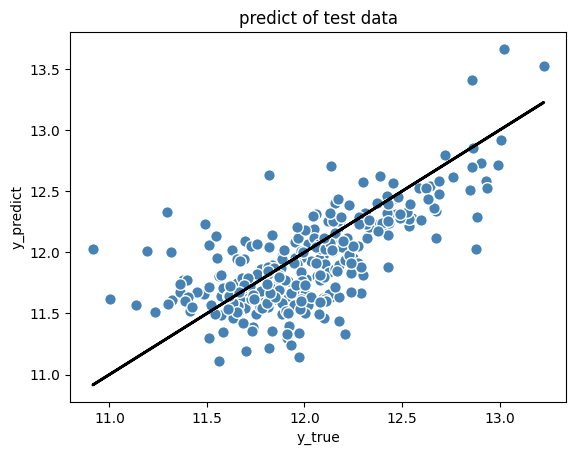

In [63]:
eva_class = ep.evaluation_show(X_train, y_train, X_valid, y_valid, model)
eva_class.show_result()

## keras_tunerでのチューニング

In [52]:
from tensorflow import keras
from tensorflow.keras import layers
from keras_tuner import RandomSearch

def build_model(hp):
    model = keras.Sequential()
    
    model.add(layers.Flatten())
    model.add(
        layers.Dense(
            units=hp.Int("units", min_value=16, max_value=512, step=32),
            activation="relu",
        )
    )
    model.add(
        layers.Dropout(0.2)
    )
    model.add(layers.Dense(1))
    model.compile(
        optimizer=keras.optimizers.Adam(
            hp.Choice("learning_rate", values=[1e-2, 1e-3, 1e-4])
        ),
        loss="mse"
    )
    return model

In [53]:
tuner = RandomSearch(
    build_model,
    max_trials=3,
    executions_per_trial=2,
    overwrite=True
)

tuner.search_space_summary()

Search space summary
Default search space size: 2
units (Int)
{'default': None, 'conditions': [], 'min_value': 16, 'max_value': 512, 'step': 32, 'sampling': None}
learning_rate (Choice)
{'default': 0.01, 'conditions': [], 'values': [0.01, 0.001, 0.0001], 'ordered': True}


In [54]:
X_train.shape

(1165, 13)

In [55]:
y_train.shape

(1165,)

In [56]:
tuner.search(X_train, y_train, epochs=2, validation_data=(X_valid, y_valid))


Search: Running Trial #1

Value             |Best Value So Far |Hyperparameter
272               |?                 |units
0.0001            |?                 |learning_rate

Epoch 1/2
37/37 [==============================] - 0s 3ms/step - loss: 73057.1484 - val_loss: 14982.4473
Epoch 2/2
37/37 [==============================] - 0s 2ms/step - loss: 19350.6875 - val_loss: 2666.3376


TypeError: Expected the return value of HyperModel.fit() to be a single float when `objective` is left unspecified. Recevied return value: <keras.callbacks.History object at 0xffff367226a0> of type <class 'keras.callbacks.History'>.

In [21]:
import imp
from keras.layers import Dense, Dropout
from keras.models import Sequential
from sklearn.metrics import log_loss
from sklearn.preprocessing import StandardScaler

# NN構成
model = Sequential()
model.add(Dense(64, activation="relu", input_shape=(X_train.shape[1],)))
#model.add(Dropout(0, 2))
model.add(Dense(64, activation="relu"))
#model.add(Dropout(0, 2))
model.add(Dense(1, activation="sigmoid"))

model.compile(loss="mean_squared_error",
            optimizer="adam",
            metrics = ['mae', 'mse'])

batch_size = X_train.shape[0]//5
epochs = 10
history = model.fit(X_train, y_train,
                    #batch_size=batch_size, 
                    epochs=epochs, 
                    validation_split = 0.2,
                    verbose=0, 
                    validation_data=(X_valid, y_valid))

y_pred = model.predict(X_valid)
score = log_loss(y_valid, y_pred, eps=1e-7)
print(f"logloss: {score:.4f}")

10/10 [==============================] - 0s 523us/step


ValueError: Unknown label type: (411     11.884489
211     12.133502
342     11.379394
303     11.917724
159     12.676076
          ...    
92      12.004568
1184    12.137258
295     11.867097
919     12.081076
40      11.982929
Name: SalePrice, Length: 292, dtype: float64,)

In [149]:
eva_class = ep.evaluation_show_pytorch(X_train, y_train, X_valid, y_valid, net)
eva_class.show_result()

ValueError: Input contains NaN, infinity or a value too large for dtype('float32').

### 疑問点・考察
- 線形カーネルを使った場合はCVに30分以上かかったが、rbfカーネルだと1分程度で終わったのはなぜか？
- 非線形回帰(カーネルSVR, ランダムフォレスト回帰)を使ってもあまり性能が良くならなかった。
- 前処理を見直す必要がある？
- 他の非線形モデル（NN, GBDT(XGBegressor)）を使ってみる。